In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
pip install smogn

In [ ]:
pip install imbalanced-learn

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import osmnx as ox
import networkx as nx
import time



from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score



from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from joblib import Parallel, delayed
from scipy.spatial import distance
from scipy.spatial import cKDTree
from datetime import datetime
from geopy.distance import geodesic
from scipy.stats import skew



# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows

In [ ]:
file_path = ('/content/drive/MyDrive/thesis/thesis_data_final.csv')
thesis_data = pd.read_csv(file_path)

# organize column name and remove unrelated column

host_variables = ['no', 'review_scores_rating', 'Gender', 'host_about_length', 'host_operating_years',
                  'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'host_listings_count', 'host_is_superhost', 'host_has_profile_pic',
                  'calculated_host_listings_count']


property_variables = [
    'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'price', 'amenities_count', 'instant_bookable'
]

geographical_variables = ['nearest_landmark', 'nearest_distance_km', 'stop_name', 'geometry_distance_km', 'shortest_walking_distance']



# Combine all variables into one list for selection
selected_columns = host_variables + property_variables + geographical_variables

# Create a new DataFrame with only the selected columns
thesis_data = thesis_data[selected_columns]

# Display the first few rows of the new DataFrame to verify
thesis_data.head()

,no,review_scores_rating,Gender,host_about_length,host_operating_years,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_is_superhost,host_has_profile_pic,calculated_host_listings_count,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,amenities_count,instant_bookable,nearest_landmark,nearest_distance_km,stop_name,geometry_distance_km,shortest_walking_distance
0,1,3.00,male,0,2.833333,a few days or more,20%,56%,15,f,t,4,Private room in home,Private room,2,1.0,1,1,49,9,f,Dodger Stadium,15.998652,Rosemead / Garibaldi,0.041621,0.000000
1,2,4.93,male,0,1.166667,within an hour,100%,95%,3,t,t,3,Entire rental unit,Entire home/apt,2,1.0,0,1,231,48,t,Abbot Kinney Blvd,4.165564,Broadway / 4th,0.075050,17.037615
2,3,4.61,female,30,11.833333,within a few hours,100%,82%,2,f,t,2,Entire home,Entire home/apt,7,1.0,2,5,110,28,f,Abbot Kinney Blvd,3.697183,Centinela / Culver,0.206670,0.225856
3,4,4.97,male,0,1.416667,within an hour,100%,97%,1,t,t,1,Entire home,Entire home/apt,6,3.5,4,4,1179,63,f,Venice Canals Walkway,0.062864,Washington / Via Dolce,0.206209,0.293518
4,5,5.00,female,0,3.250000,within an hour,100%,95%,25,t,t,21,Entire home,Entire home/apt,8,4.5,4,4,1244,50,f,Hollywood Bowl Overlook,3.804128,Santa Monica / Crescent Heights,0.275890,0.161334


In [ ]:
# Convert percentage strings to numeric values
thesis_data['host_response_rate'] = thesis_data['host_response_rate'].str.rstrip('%').astype(float) / 100
thesis_data['host_acceptance_rate'] = thesis_data['host_acceptance_rate'].str.rstrip('%').astype(float) / 100

thesis_data = thesis_data.drop(['no', 'property_type', 'shortest_walking_distance', 'stop_name'], axis=1)
thesis_data = thesis_data[thesis_data['Gender'] != 'unknown']
thesis_data = thesis_data.rename(columns={'geometry_distance_km': 'shortest_walking_distance_from_transportation'})
thesis_data = thesis_data.rename(columns={'nearest_distance_km': 'nearest_landmark_distance'})
thesis_data = thesis_data.rename(columns={'accommodates': 'guest_capacity'})

In [ ]:
thesis_data.columns

Index(['review_scores_rating', 'Gender', 'host_about_length',
       'host_operating_years', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count', 'host_is_superhost',
       'host_has_profile_pic', 'calculated_host_listings_count', 'room_type',
       'guest_capacity', 'bathrooms', 'bedrooms', 'beds', 'price',
       'amenities_count', 'instant_bookable', 'nearest_landmark',
       'nearest_landmark_distance',
       'shortest_walking_distance_from_transportation'],
      dtype='object')

In [ ]:
print(thesis_data['Gender'].unique())
print(thesis_data['host_response_time'].unique())
print(thesis_data['host_is_superhost'].unique())
print(thesis_data['host_has_profile_pic'].unique())
print(thesis_data['room_type'].unique())
print(thesis_data['instant_bookable'].unique())
print(thesis_data['nearest_landmark'].unique())


['male' 'female']
['a few days or more' 'within an hour' 'within a few hours' 'within a day']
['f' 't']
['t' 'f']
['Private room' 'Entire home/apt' 'Shared room' 'Hotel room']
['f' 't']
['Dodger Stadium' 'Abbot Kinney Blvd' 'Venice Canals Walkway'
 'Hollywood Bowl Overlook' 'Hollywood Forever Cemetery'
 'Pierce Brothers Westwood Village Memorial Park'
 'University of Southern California' 'Crypto.com Arena'
 'The Wizarding World of Harry Potter'
 'University of California, Los Angeles (UCLA)' 'Union Station'
 'Hollywood Hills' 'Bradbury Building' 'Grand Central Market'
 'Walt Disney Concert Hall' 'Angels Flight Railway' 'Calle Olvera'
 'City Hall' 'Cathedral Of Our Lady Of The Angels']


In [ ]:
thesis_data.head()

,review_scores_rating,Gender,host_about_length,host_operating_years,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_is_superhost,host_has_profile_pic,calculated_host_listings_count,room_type,guest_capacity,bathrooms,bedrooms,beds,price,amenities_count,instant_bookable,nearest_landmark,nearest_landmark_distance,shortest_walking_distance_from_transportation
0,3.00,male,0,2.833333,a few days or more,0.2,0.56,15,f,t,4,Private room,2,1.0,1,1,49,9,f,Dodger Stadium,15.998652,0.041621
1,4.93,male,0,1.166667,within an hour,1.0,0.95,3,t,t,3,Entire home/apt,2,1.0,0,1,231,48,t,Abbot Kinney Blvd,4.165564,0.075050
2,4.61,female,30,11.833333,within a few hours,1.0,0.82,2,f,t,2,Entire home/apt,7,1.0,2,5,110,28,f,Abbot Kinney Blvd,3.697183,0.206670
3,4.97,male,0,1.416667,within an hour,1.0,0.97,1,t,t,1,Entire home/apt,6,3.5,4,4,1179,63,f,Venice Canals Walkway,0.062864,0.206209
4,5.00,female,0,3.250000,within an hour,1.0,0.95,25,t,t,21,Entire home/apt,8,4.5,4,4,1244,50,f,Hollywood Bowl Overlook,3.804128,0.275890


In [ ]:
# Assuming thesis_data is your DataFrame and review_scores_rating is the column to evaluate

# Create a new column 'review_rating_class' based on conditions
thesis_data['review_rating_class'] = thesis_data['review_scores_rating'].apply(lambda x: 'low' if x <= 4 else 'high')

# Display the first few rows to verify
print(thesis_data[['review_scores_rating', 'review_rating_class']].head())


   review_scores_rating review_rating_class
0                  3.00                 low
1                  4.93                high
2                  4.61                high
3                  4.97                high
4                  5.00                high


In [ ]:


# Generate summary statistics for numerical variables
numerical_summary = thesis_data[['host_about_length', 'host_operating_years', 'amenities_count',
                                 'nearest_landmark_distance', 'shortest_walking_distance_from_transportation']].describe()

# Generate counts for categorical variables
gender_counts = thesis_data['Gender'].value_counts()
landmark_counts = thesis_data['nearest_landmark'].value_counts()

# Convert numerical summary to LaTeX table
numerical_summary_latex = numerical_summary.to_latex(index=True)

# Prepare categorical summary for LaTeX
gender_counts_latex = gender_counts.to_frame(name='Counts').to_latex(index=True)
landmark_counts_latex = landmark_counts.to_frame(name='Counts').to_latex(index=True)

# Save LaTeX tables
with open("numerical_summary.tex", "w") as f:
    f.write(numerical_summary_latex)

with open("gender_counts.tex", "w") as f:
    f.write(gender_counts_latex)

with open("landmark_counts.tex", "w") as f:
    f.write(landmark_counts_latex)

numerical_summary, gender_counts, landmark_counts


(       host_about_length  host_operating_years  amenities_count  \
 count       24929.000000          24929.000000     24929.000000   
 mean           32.572626              7.063049        42.553291   
 std            50.305083              3.555780        16.192950   
 min             0.000000              0.080000         0.000000   
 25%             0.000000              4.083333        31.000000   
 50%            11.000000              7.666667        43.000000   
 75%            52.000000              9.750000        54.000000   
 max           735.000000             16.166667       111.000000   
 
        nearest_landmark_distance  \
 count               24929.000000   
 mean                   12.814324   
 std                    13.352619   
 min                     0.027027   
 25%                     3.451377   
 50%                     7.391643   
 75%                    18.152914   
 max                    82.999648   
 
        shortest_walking_distance_from_transportati

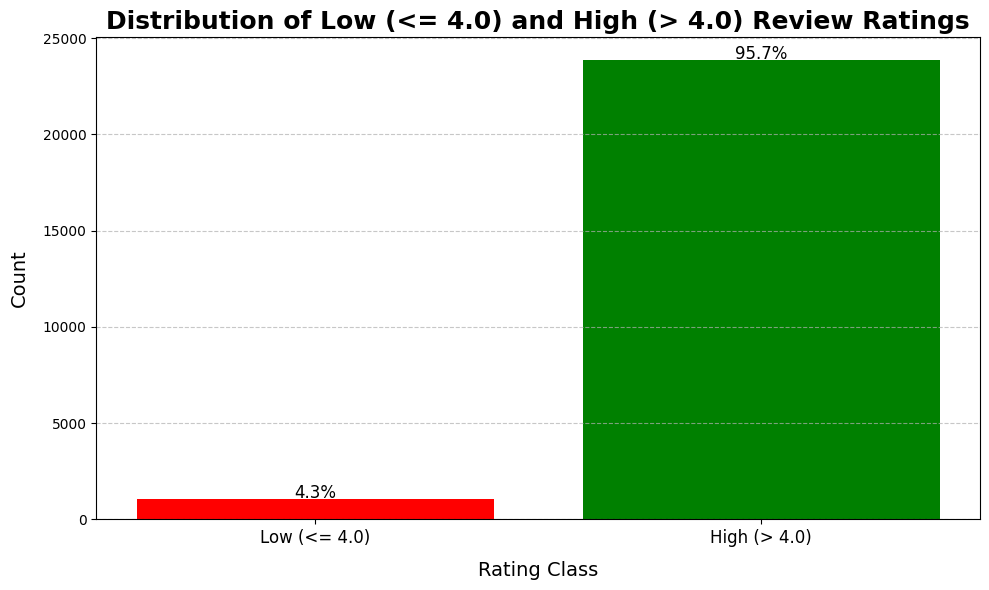

In [ ]:
import matplotlib.pyplot as plt

# Calculate counts for each class, explicitly ordering 'low' and 'high'
rating_class_counts = thesis_data['review_rating_class'].value_counts()
rating_class_counts = rating_class_counts[['low', 'high']]  # Ensure the correct order

# Calculate percentage for each class
rating_class_percentage = (rating_class_counts / rating_class_counts.sum()) * 100

# Plot with percentages on top of bars
plt.figure(figsize=(10, 6))
bars = plt.bar(rating_class_counts.index, rating_class_counts, color=['red', 'green'])

# Add percentages on top of bars
for bar, percentage in zip(bars, rating_class_percentage):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50, f'{percentage:.1f}%',
             ha='center', fontsize=12, color='black')

# Beautify the plot
plt.title('Distribution of Low (<= 4.0) and High (> 4.0) Review Ratings', fontsize=18, fontweight='bold')
plt.xlabel('Rating Class', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(ticks=[0, 1], labels=['Low (<= 4.0)', 'High (> 4.0)'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


In [ ]:
#rating_class 0 : low and 1: high
thesis_data.head()

,review_scores_rating,Gender,host_about_length,host_operating_years,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_is_superhost,host_has_profile_pic,calculated_host_listings_count,room_type,guest_capacity,bathrooms,bedrooms,beds,price,amenities_count,instant_bookable,nearest_landmark,nearest_landmark_distance,shortest_walking_distance_from_transportation,review_rating_class
0,3.00,male,0,2.833333,a few days or more,0.2,0.56,15,f,t,4,Private room,2,1.0,1,1,49,9,f,Dodger Stadium,15.998652,0.041621,low
1,4.93,male,0,1.166667,within an hour,1.0,0.95,3,t,t,3,Entire home/apt,2,1.0,0,1,231,48,t,Abbot Kinney Blvd,4.165564,0.075050,high
2,4.61,female,30,11.833333,within a few hours,1.0,0.82,2,f,t,2,Entire home/apt,7,1.0,2,5,110,28,f,Abbot Kinney Blvd,3.697183,0.206670,high
3,4.97,male,0,1.416667,within an hour,1.0,0.97,1,t,t,1,Entire home/apt,6,3.5,4,4,1179,63,f,Venice Canals Walkway,0.062864,0.206209,high
4,5.00,female,0,3.250000,within an hour,1.0,0.95,25,t,t,21,Entire home/apt,8,4.5,4,4,1244,50,f,Hollywood Bowl Overlook,3.804128,0.275890,high


In [ ]:
rating_class_counts

,count
review_rating_class,
low,1073
high,23856


In [ ]:
thesis_data.head()

,review_scores_rating,Gender,host_about_length,host_operating_years,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_is_superhost,host_has_profile_pic,calculated_host_listings_count,room_type,guest_capacity,bathrooms,bedrooms,beds,price,amenities_count,instant_bookable,nearest_landmark,nearest_landmark_distance,shortest_walking_distance_from_transportation,review_rating_class
0,3.00,male,0,2.833333,a few days or more,0.2,0.56,15,f,t,4,Private room,2,1.0,1,1,49,9,f,Dodger Stadium,15.998652,0.041621,low
1,4.93,male,0,1.166667,within an hour,1.0,0.95,3,t,t,3,Entire home/apt,2,1.0,0,1,231,48,t,Abbot Kinney Blvd,4.165564,0.075050,high
2,4.61,female,30,11.833333,within a few hours,1.0,0.82,2,f,t,2,Entire home/apt,7,1.0,2,5,110,28,f,Abbot Kinney Blvd,3.697183,0.206670,high
3,4.97,male,0,1.416667,within an hour,1.0,0.97,1,t,t,1,Entire home/apt,6,3.5,4,4,1179,63,f,Venice Canals Walkway,0.062864,0.206209,high
4,5.00,female,0,3.250000,within an hour,1.0,0.95,25,t,t,21,Entire home/apt,8,4.5,4,4,1244,50,f,Hollywood Bowl Overlook,3.804128,0.275890,high


In [ ]:
thesis_data.columns

Index(['review_scores_rating', 'Gender', 'host_about_length',
       'host_operating_years', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count', 'host_is_superhost',
       'host_has_profile_pic', 'calculated_host_listings_count', 'room_type',
       'guest_capacity', 'bathrooms', 'bedrooms', 'beds', 'price',
       'amenities_count', 'instant_bookable', 'nearest_landmark',
       'nearest_landmark_distance',
       'shortest_walking_distance_from_transportation', 'review_rating_class'],
      dtype='object')

# Last

In [ ]:
numerical_features

['host_about_length',
 'host_operating_years',
 'host_response_rate',
 'host_acceptance_rate',
 'host_listings_count',
 'calculated_host_listings_count',
 'guest_capacity',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'amenities_count',
 'nearest_landmark',
 'nearest_landmark_distance',
 'shortest_walking_distance_from_transportation']

In [ ]:
X_train.head()

# Model test (Host + Property variables)

In [ ]:
# Define features and target
host_features = ['Gender', 'host_about_length', 'host_operating_years',
                 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'host_listings_count', 'host_is_superhost', 'host_has_profile_pic']

property_features = ['room_type', 'guest_capacity', 'bathrooms', 'bedrooms',
                     'beds', 'price', 'amenities_count', 'instant_bookable',
                     'calculated_host_listings_count']

categorical_features = ['Gender', 'host_response_time', 'host_is_superhost',
                        'host_has_profile_pic', 'room_type', 'instant_bookable']



numerical_features = [col for col in thesis_data.columns if col not in categorical_features + ['review_scores_rating', 'review_rating_class', 'nearest_landmark',
 'nearest_landmark_distance', 'shortest_walking_distance_from_transportation']]

X_airbnb = thesis_data[host_features + property_features]
y = thesis_data['review_rating_class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_airbnb, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Class distribution after SMOTE:
review_rating_class
high    19085
low     19085
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Step 1: Convert target values to integers
le = LabelEncoder()
y_train_resampled = le.fit_transform(y_train_resampled)  # 'high'/'low' -> 0/1
y_test = le.transform(y_test)  # 'high'/'low' -> 0/1

# 확인: 클래스 매핑 정보
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Step 2: Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Step 3: Train and evaluate each model
results = []

for model_name, model in models.items():
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # For AUC

    # Evaluate the model
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob)

    # Append results
    results.append({
        "Model": model_name,
        "Accuracy": report['accuracy'],
        "Precision (Low)": report['1']['precision'],  # 숫자형 레이블 사용
        "Recall (Low)": report['1']['recall'],
        "F1-Score (Low)": report['1']['f1-score'],
        "AUC": auc
    })

    # Print model performance
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {auc:.3f}")
    print("-" * 50)

# Step 4: Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Class mapping: {'high': 0, 'low': 1}
Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      4771
           1       0.10      0.70      0.18       215

    accuracy                           0.72      4986
   macro avg       0.54      0.71      0.51      4986
weighted avg       0.94      0.72      0.81      4986

AUC: 0.793
--------------------------------------------------
Model: Random Forest
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4771
           1       0.21      0.16      0.18       215

    accuracy                           0.94      4986
   macro avg       0.59      0.57      0.58      4986
weighted avg       0.93      0.94      0.93      4986

AUC: 0.794
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:07:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4771
           1       0.28      0.22      0.25       215

    accuracy                           0.94      4986
   macro avg       0.62      0.60      0.61      4986
weighted avg       0.94      0.94      0.94      4986

AUC: 0.811
--------------------------------------------------
Model: MLP
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4771
           1       0.16      0.37      0.22       215

    accuracy                           0.89      4986
   macro avg       0.56      0.64      0.58      4986
weighted avg       0.93      0.89      0.91      4986

AUC: 0.720
--------------------------------------------------
Model: SVM
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      4771
           1       0.11      0.61      0.19       215

    accuracy         

In [ ]:
thesis_data.columns

Index(['review_scores_rating', 'Gender', 'host_about_length',
       'host_operating_years', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count', 'host_is_superhost',
       'host_has_profile_pic', 'calculated_host_listings_count', 'room_type',
       'guest_capacity', 'bathrooms', 'bedrooms', 'beds', 'price',
       'amenities_count', 'instant_bookable', 'nearest_landmark',
       'nearest_landmark_distance',
       'shortest_walking_distance_from_transportation', 'review_rating_class'],
      dtype='object')

# Airbnb + geographical

In [ ]:
# Define host, property, and geographical variables
host_features = ['Gender', 'host_about_length', 'host_operating_years',
                 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'host_listings_count', 'host_is_superhost', 'host_has_profile_pic']

property_features = ['room_type', 'guest_capacity', 'bathrooms', 'bedrooms',
                     'beds', 'price', 'amenities_count', 'instant_bookable',
                     'calculated_host_listings_count']

geographical_features = ['nearest_landmark', 'nearest_landmark_distance', 'shortest_walking_distance_from_transportation']

# Define datasets
X_airbnb = thesis_data[host_features + property_features]
X_airbnb_geo = thesis_data[host_features + property_features + geographical_features]
y = thesis_data['review_rating_class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_airbnb, y, test_size=0.2, stratify=y, random_state=42)
X_train_geo, X_test_geo, y_train_geo, y_test_geo = train_test_split(X_airbnb_geo, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing for Airbnb dataset
categorical_features = ['Gender', 'host_response_time', 'host_is_superhost',
                        'host_has_profile_pic', 'room_type', 'instant_bookable']
numerical_features = ['host_about_length', 'host_operating_years',
                      'host_response_rate', 'host_acceptance_rate',
                      'host_listings_count', 'guest_capacity', 'bathrooms',
                      'bedrooms', 'beds', 'price', 'amenities_count',
                      'calculated_host_listings_count']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define preprocessing for Airbnb + Geographical dataset
categorical_features_geo = categorical_features + ['nearest_landmark']
numerical_features_geo = numerical_features + ['nearest_landmark_distance', 'shortest_walking_distance_from_transportation']

preprocessor_geo = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_geo),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_geo)
    ]
)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train_geo = preprocessor_geo.fit_transform(X_train_geo)
X_test_geo = preprocessor_geo.transform(X_test_geo)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_geo_resampled, y_train_geo_resampled = smote.fit_resample(X_train_geo, y_train_geo)

# Check processed data
print("Airbnb dataset processed shape:", X_train_resampled.shape)
print("Airbnb + Geographical dataset processed shape:", X_train_geo_resampled.shape)


Airbnb dataset processed shape: (38170, 28)
Airbnb + Geographical dataset processed shape: (38170, 49)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

# Transform target values to integers
le = LabelEncoder()
y_train_geo_resampled = le.fit_transform(y_train_geo_resampled)
y_test_geo = le.transform(y_test_geo)

print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Evaluate models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_geo_resampled, y_train_geo_resampled)

    # Predict on the test set
    y_pred = model.predict(X_test_geo)
    y_prob = model.predict_proba(X_test_geo)[:, 1]

    # Evaluate the model
    report = classification_report(y_test_geo, y_pred, output_dict=True)
    auc = roc_auc_score(y_test_geo, y_prob)

    # Append results
    results.append({
        "Model": model_name,
        "Dataset": dataset_name,
        "Accuracy": report['accuracy'],
        "Precision (Low)": report['1']['precision'],  # 숫자형 레이블 '1'
        "Recall (Low)": report['1']['recall'],
        "F1-Score (Low)": report['1']['f1-score'],
        "AUC": auc
    })

    # Print model performance
    print(f"Model: {model_name} | Dataset: {dataset_name}")
    print(classification_report(y_test_geo, y_pred))
    print(f"AUC: {auc:.3f}")
    print("-" * 50)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV for further analysis
results_df.to_csv("model_comparison_geo_encoded.csv", index=False)


Class mapping: {'high': 0, 'low': 1}
Model: Logistic Regression | Dataset: Airbnb + Geographical Variables
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      4771
           1       0.11      0.69      0.19       215

    accuracy                           0.75      4986
   macro avg       0.55      0.72      0.52      4986
weighted avg       0.94      0.75      0.82      4986

AUC: 0.803
--------------------------------------------------
Model: Random Forest | Dataset: Airbnb + Geographical Variables
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4771
           1       0.25      0.17      0.20       215

    accuracy                           0.94      4986
   macro avg       0.61      0.57      0.59      4986
weighted avg       0.93      0.94      0.94      4986

AUC: 0.804
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:49:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost | Dataset: Airbnb + Geographical Variables
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4771
           1       0.29      0.19      0.23       215

    accuracy                           0.95      4986
   macro avg       0.63      0.58      0.60      4986
weighted avg       0.93      0.95      0.94      4986

AUC: 0.807
--------------------------------------------------
Model: MLP | Dataset: Airbnb + Geographical Variables
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4771
           1       0.18      0.27      0.22       215

    accuracy                           0.91      4986
   macro avg       0.57      0.61      0.59      4986
weighted avg       0.93      0.91      0.92      4986

AUC: 0.728
--------------------------------------------------
Model: SVM | Dataset: Airbnb + Geographical Variables
              precision    recall  f1-score   support

 

In [ ]:
print("Unique classes in y_test:", set(y_test))
print("Unique classes in y_pred:", set(y_pred))

Unique classes in y_test: {'high', 'low'}
Unique classes in y_pred: {'high', 'low'}


In [ ]:
from xgboost import XGBClassifier
import pandas as pd

# Train XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train_geo_resampled, y_train_geo_resampled)

# Feature names for the dataset
feature_names = preprocessor_geo.get_feature_names_out()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:53:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)


In [ ]:
# Get top 15 features
top_15_features = importance_df.head(15)

print("Top 15 Most Important Features:")
print(top_15_features)


Top 15 Most Important Features:
                                              Feature  Importance
20                           cat__host_is_superhost_f    0.216599
15                                   cat__Gender_male    0.100152
11                num__calculated_host_listings_count    0.046793
42  cat__nearest_landmark_Pierce Brothers Westwood...    0.040424
21                           cat__host_is_superhost_t    0.036337
29                            cat__instant_bookable_t    0.032470
47        cat__nearest_landmark_Venice Canals Walkway    0.031987
30            cat__nearest_landmark_Abbot Kinney Blvd    0.029758
37               cat__nearest_landmark_Dodger Stadium    0.029588
45  cat__nearest_landmark_University of California...    0.028462
40   cat__nearest_landmark_Hollywood Forever Cemetery    0.028440
43  cat__nearest_landmark_The Wizarding World of H...    0.028322
28                            cat__instant_bookable_f    0.026109
46  cat__nearest_landmark_University of Sout

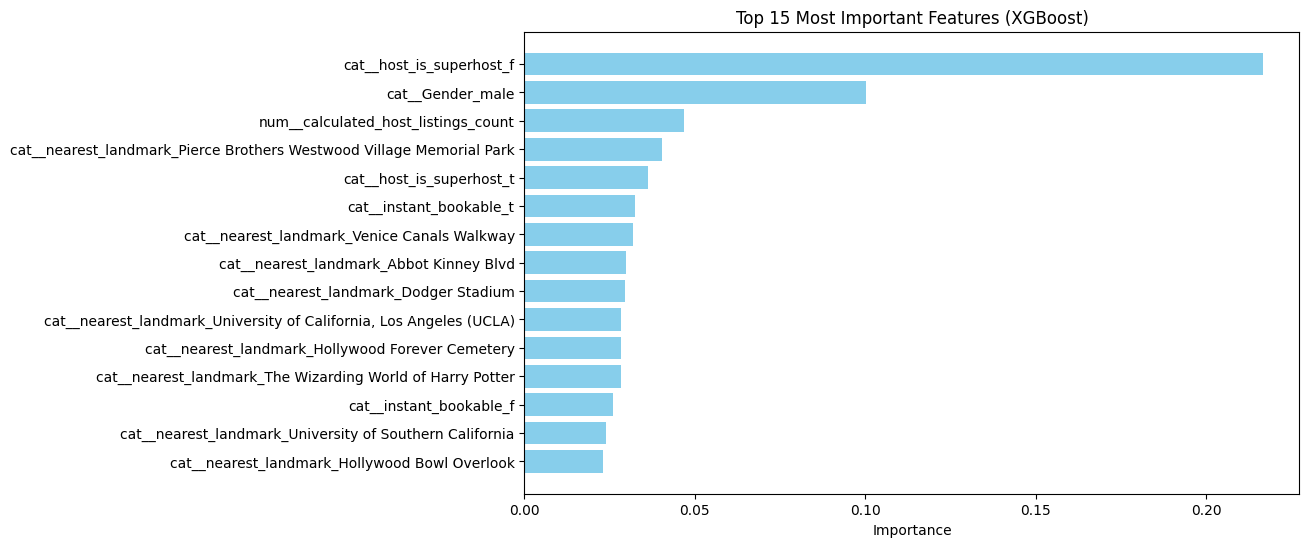

In [ ]:
import matplotlib.pyplot as plt

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.xlabel("Importance")
plt.title("Top 15 Most Important Features (XGBoost)")
plt.show()


In [ ]:
# all
all_features = importance_df.head(1000)

print("complete feature importance ranking:")
print(all_features)


complete feature importance ranking:
                                              Feature  Importance
20                           cat__host_is_superhost_f    0.216599
15                                   cat__Gender_male    0.100152
11                num__calculated_host_listings_count    0.046793
42  cat__nearest_landmark_Pierce Brothers Westwood...    0.040424
21                           cat__host_is_superhost_t    0.036337
29                            cat__instant_bookable_t    0.032470
47        cat__nearest_landmark_Venice Canals Walkway    0.031987
30            cat__nearest_landmark_Abbot Kinney Blvd    0.029758
37               cat__nearest_landmark_Dodger Stadium    0.029588
45  cat__nearest_landmark_University of California...    0.028462
40   cat__nearest_landmark_Hollywood Forever Cemetery    0.028440
43  cat__nearest_landmark_The Wizarding World of H...    0.028322
28                            cat__instant_bookable_f    0.026109
46  cat__nearest_landmark_University of

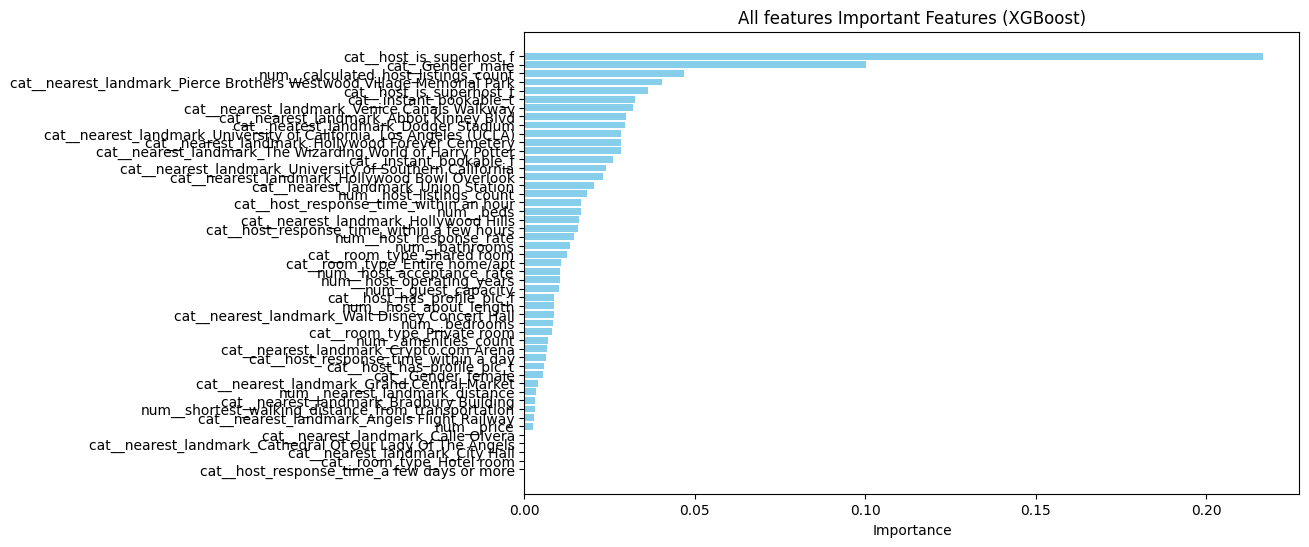

In [ ]:
import matplotlib.pyplot as plt

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(all_features['Feature'], all_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.xlabel("Importance")
plt.title("All features Important Features (XGBoost)")
plt.show()


In [ ]:
X_test[:,1]

array([-1.13683691,  0.78100469,  1.178606  , ...,  0.61728651,
        0.0325787 , -0.17791611])

In [ ]:
X_train_geo_resampled[:1]

array([[-0.64762428,  0.4067917 ,  0.24384663, -0.04651416, -0.12457568,
        -0.06988381, -0.55357995,  0.20176748, -0.15985889, -0.07009853,
         1.32160234, -0.27291787, -0.77600795, -0.32945666,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

In [ ]:
X_test_geo[:, 1]

array([-1.13683691,  0.78100469,  1.178606  , ...,  0.61728651,
        0.0325787 , -0.17791611])

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind
from xgboost import XGBClassifier

# Ensure target values are consistently binary (0 or 1)
def encode_target(values):
    target_mapping = {'low': 0, 'high': 1}
    return np.array([target_mapping[val] if val in target_mapping else val for val in values])

# Transform all target variables
y_train_resampled_encoded = encode_target(y_train_resampled)
y_test_encoded = encode_target(y_test)
y_train_geo_resampled_encoded = encode_target(y_train_geo_resampled)
y_test_geo_encoded = encode_target(y_test_geo)

# Step 1: Train baseline model
baseline_model = XGBClassifier(random_state=42, eval_metric="logloss")
baseline_model.fit(X_train_resampled, y_train_resampled_encoded)
baseline_preds = baseline_model.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score(y_test_encoded, baseline_preds)

# Step 2: Train extended model
extended_model = XGBClassifier(random_state=42, eval_metric="logloss")
extended_model.fit(X_train_geo_resampled, y_train_geo_resampled_encoded)
extended_preds = extended_model.predict_proba(X_test_geo)[:, 1]
extended_auc = roc_auc_score(y_test_geo_encoded, extended_preds)

# Step 3: Compare AUC statistically
baseline_auc_array = np.full(100, baseline_auc)
extended_auc_array = np.full(100, extended_auc)

stat, p_value = ttest_ind(baseline_auc_array, extended_auc_array)
print(f"Baseline AUC: {baseline_auc}")
print(f"Extended AUC: {extended_auc}")
print(f"P-value for AUC difference: {p_value}")


Baseline AUC: 0.8110371283871061
Extended AUC: 0.8066969530058055
P-value for AUC difference: 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
y_train_geo_resampled_encoded = pd.Series(y_train_geo_resampled_encoded).fillna(0).values  # 0으로 대체


Missing values in X_train_geo_resampled: False
Missing values in y_train_geo_resampled_encoded: True


# walking distance 제외하고 다시

In [ ]:
# Define target mapping
target_mapping = {'low': 0, 'high': 1}

# Map target values to 0 and 1
y_train_geo_reduced_encoded = np.array([target_mapping[val] for val in y_train_geo_reduced])
y_test_geo_reduced_encoded = np.array([target_mapping[val] for val in y_test_geo_reduced])

# Apply SMOTE for reduced dataset
smote = SMOTE(random_state=42)
X_train_geo_reduced_resampled, y_train_geo_reduced_resampled = smote.fit_resample(
    X_train_geo_reduced_processed, y_train_geo_reduced_encoded
)

# Train extended model with reduced geographical variables
extended_model_reduced = XGBClassifier(random_state=42, eval_metric="logloss")
extended_model_reduced.fit(X_train_geo_reduced_resampled, y_train_geo_reduced_resampled)
extended_preds_reduced = extended_model_reduced.predict_proba(X_test_geo_reduced_processed)[:, 1]
extended_auc_reduced = roc_auc_score(y_test_geo_reduced_encoded, extended_preds_reduced)

print(f"Extended AUC (Reduced Geographical Variables): {extended_auc_reduced}")


Extended AUC (Reduced Geographical Variables): 0.8022232187684314


In [ ]:
# Baseline AUC vs All Geographical Variables AUC vs Reduced Geographical Variables AUC
print(f"Baseline AUC: {baseline_auc}")
print(f"Extended AUC (All Geographical Variables): {extended_auc}")
print(f"Extended AUC (Reduced Geographical Variables): {extended_auc_reduced}")


Baseline AUC: 0.8110371283871061
Extended AUC (All Geographical Variables): 0.8066969530058055
Extended AUC (Reduced Geographical Variables): 0.8022232187684314


In [ ]:
from scipy.stats import ttest_ind

# Create arrays for statistical comparison
baseline_auc_array = np.full(100, baseline_auc)
extended_auc_array = np.full(100, extended_auc)
reduced_auc_array = np.full(100, extended_auc_reduced)

# Compare Baseline vs All Geographical Variables
stat_all, p_value_all = ttest_ind(baseline_auc_array, extended_auc_array)
print(f"P-value (Baseline vs All Geographical): {p_value_all}")

# Compare Baseline vs Reduced Geographical Variables
stat_reduced, p_value_reduced = ttest_ind(baseline_auc_array, reduced_auc_array)
print(f"P-value (Baseline vs Reduced Geographical): {p_value_reduced}")


P-value (Baseline vs All Geographical): 0.0
P-value (Baseline vs Reduced Geographical): 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


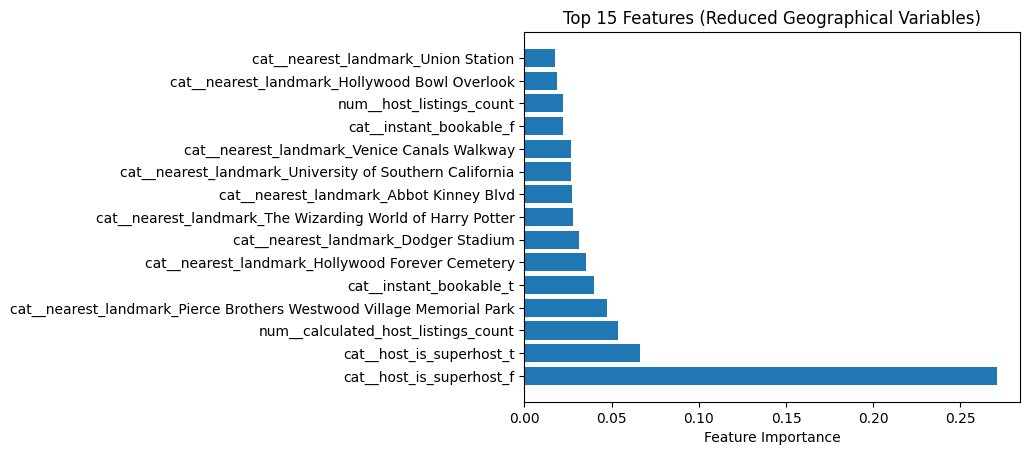

In [ ]:
import matplotlib.pyplot as plt

# Feature importance for reduced geographical model
feature_importances = extended_model_reduced.feature_importances_
sorted_idx = feature_importances.argsort()[-15:][::-1]  # Top 15 features
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [preprocessor_geo_reduced.get_feature_names_out()[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features (Reduced Geographical Variables)")
plt.show()


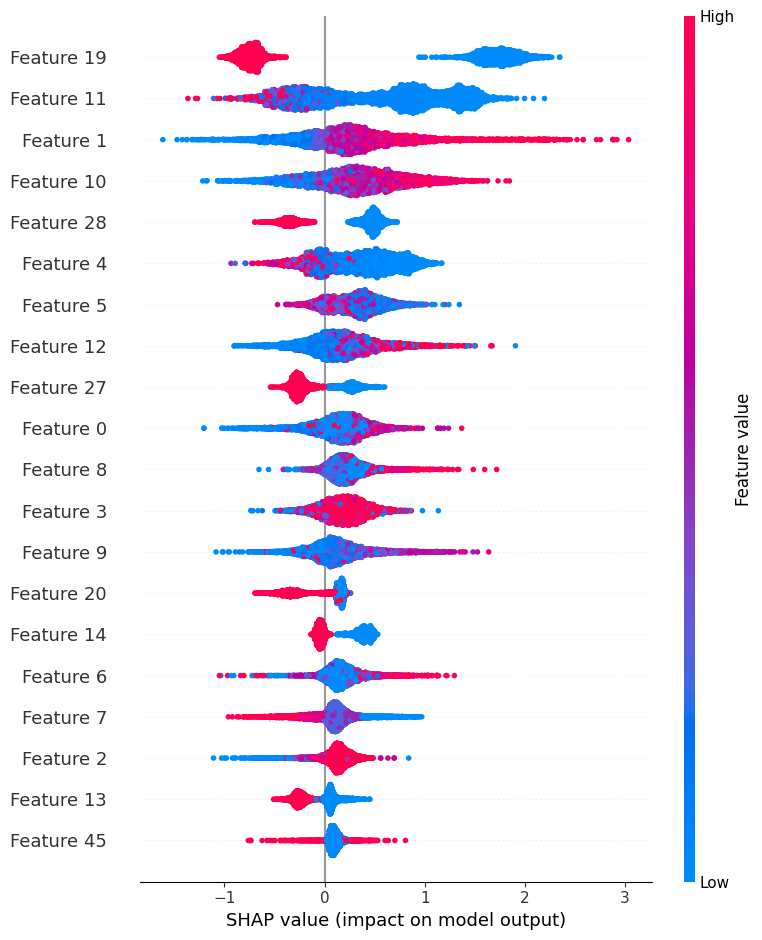

In [ ]:
import shap
shap.initjs()

# SHAP 분석 수행
explainer = shap.TreeExplainer(extended_model_reduced)
shap_values = explainer.shap_values(X_test_geo_reduced_processed)

# Summary Plot
shap.summary_plot(shap_values, X_test_geo_reduced_processed)


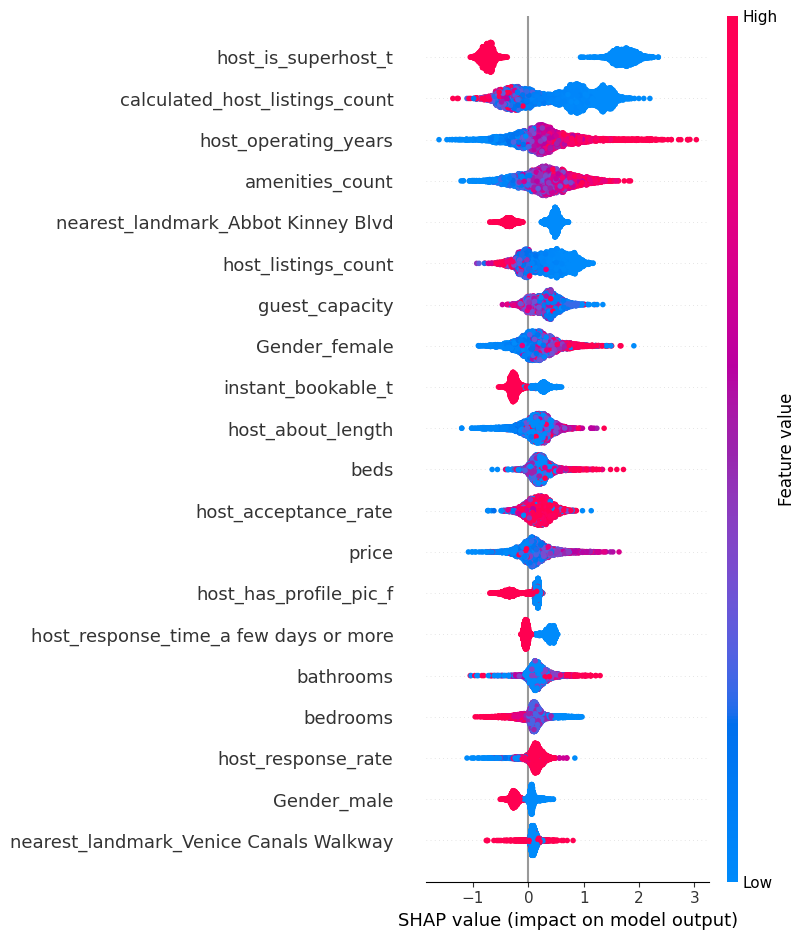

In [ ]:
# Get feature names from the preprocessor
numerical_feature_names = numerical_features
categorical_feature_names = preprocessor_geo_reduced.named_transformers_['cat'].get_feature_names_out()

# Combine all feature names
all_feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Map SHAP feature indices to names
shap.summary_plot(shap_values, X_test_geo_reduced_processed, feature_names=all_feature_names)


In [ ]:
import shap
import matplotlib.pyplot as plt

# Train XGBoost model for the baseline dataset (host + property variables)
baseline_model = XGBClassifier(random_state=42, eval_metric="logloss")
baseline_model.fit(X_train_resampled, y_train_resampled)

# Train XGBoost model for the extended dataset (host + property + geographical variables)
extended_model = XGBClassifier(random_state=42, eval_metric="logloss")
extended_model.fit(X_train_geo_resampled, y_train_geo_resampled)

# Compute SHAP values for both models
explainer_baseline = shap.Explainer(baseline_model, X_train_resampled)
shap_values_baseline = explainer_baseline(X_test)

explainer_extended = shap.Explainer(extended_model, X_train_geo_resampled)
shap_values_extended = explainer_extended(X_test_geo)

# SHAP summary plots
plt.title("Baseline Model (Host + Property Variables)")
shap.summary_plot(shap_values_baseline, X_test, feature_names=all_feature_names)

plt.title("Extended Model (Host + Property + Geographical Variables)")
shap.summary_plot(shap_values_extended, X_test_geo, feature_names=all_feature_names_geo)


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['high' 'low']

In [ ]:
# Get mean absolute SHAP values for each feature
mean_shap_values_extended = shap_values_extended.abs.mean(0).values
top_features_indices = mean_shap_values_extended.argsort()[-10:]
top_features = [all_feature_names_geo[i] for i in top_features_indices]

# Display the top 10 features with their SHAP importance
for feature, importance in zip(top_features, mean_shap_values_extended[top_features_indices]):
    print(f"{feature}: {importance:.4f}")


In [ ]:
# Define settings
settings = {
    "Baseline": X_train_resampled,
    "Setting 1": X_train_geo_resampled,  # Add geographical variables
    "Setting 2": X_train_geo_resampled,  # Add distance variables
}

# Evaluate each setting
results = []
for name, data in settings.items():
    model = XGBClassifier(random_state=42)
    model.fit(data, y_train_resampled)
    preds = model.predict_proba(X_test_geo)[:, 1]
    auc = roc_auc_score(y_test_geo, preds)
    results.append({"Setting": name, "AUC": auc})

# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


# systematic bias or disparate impact

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Train and evaluate separate models for geographical and host variables
geo_model = XGBClassifier(random_state=42, eval_metric="logloss")
geo_model.fit(X_train_geo_resampled, y_train_geo_resampled)
geo_preds = geo_model.predict_proba(X_test_geo)[:, 1]
geo_auc = roc_auc_score(y_test_geo, geo_preds)

host_model = XGBClassifier(random_state=42, eval_metric="logloss")
host_model.fit(X_train_host_resampled, y_train_host_resampled)
host_preds = host_model.predict_proba(X_test_host)[:, 1]
host_auc = roc_auc_score(y_test_host, host_preds)

# Print and compare results
print(f"Geographical Variables AUC: {geo_auc}")
print(f"Host Variables AUC: {host_auc}")


NameError: name 'X_train_host_resampled' is not defined

In [ ]:
# Define host-specific variables
host_features = ['Gender', 'host_about_length', 'host_operating_years',
                 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                 'host_listings_count', 'host_is_superhost', 'host_has_profile_pic']

X_host = thesis_data[host_features]
y = thesis_data['review_rating_class']  # Target variable

# Train-test split
X_train_host, X_test_host, y_train_host, y_test_host = train_test_split(
    X_host, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing for host variables
categorical_features_host = ['Gender', 'host_response_time', 'host_is_superhost', 'host_has_profile_pic']
numerical_features_host = ['host_about_length', 'host_operating_years', 'host_response_rate',
                           'host_acceptance_rate', 'host_listings_count']

preprocessor_host = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_host),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_host)
    ]
)

# Define mapping for target variable
target_mapping = {'low': 0, 'high': 1}

# Map the target variable to numerical values
y_train_host_encoded = y_train_host.map(target_mapping)
y_test_host_encoded = y_test_host.map(target_mapping)

# Apply SMOTE for host-specific dataset
smote = SMOTE(random_state=42)
X_train_host_resampled, y_train_host_resampled_encoded = smote.fit_resample(
    X_train_host_processed, y_train_host_encoded
)

# Train and evaluate the host-specific model
host_model = XGBClassifier(random_state=42, eval_metric="logloss")
host_model.fit(X_train_host_resampled, y_train_host_resampled_encoded)



# Predictions and AUC
host_preds = host_model.predict_proba(X_test_host_processed)[:, 1]
host_auc = roc_auc_score(y_test_host, host_preds)

print(f"Host Variables AUC: {host_auc}")


Host Variables AUC: 0.2022334550311231


In [ ]:
# systematic bias analysis
# Grouped performance for a specific variable
from sklearn.metrics import classification_report
import pandas as pd

# Split test data into subgroups
superhost_true = X_test[y_test['host_is_superhost'] == 1]
superhost_false = X_test[y_test['host_is_superhost'] == 0]

# Evaluate model performance on each subgroup
for subgroup, data in zip(['Superhost', 'Non-Superhost'], [superhost_true, superhost_false]):
    preds = model.predict(data)
    print(f"Performance for {subgroup}:")
    print(classification_report(y_test, preds))


KeyError: 'host_is_superhost'

In [ ]:
# Calculate Disparate Impact Ratio
group_a = y_test['nearest_landmark'] == "Abbot Kinney Blvd"
group_b = y_test['nearest_landmark'] != "Abbot Kinney Blvd"

# Mean predicted probability for each group
prob_a = model.predict_proba(X_test[group_a])[:, 1].mean()
prob_b = model.predict_proba(X_test[group_b])[:, 1].mean()

disparate_impact_ratio = prob_a / prob_b
print(f"Disparate Impact Ratio: {disparate_impact_ratio}")


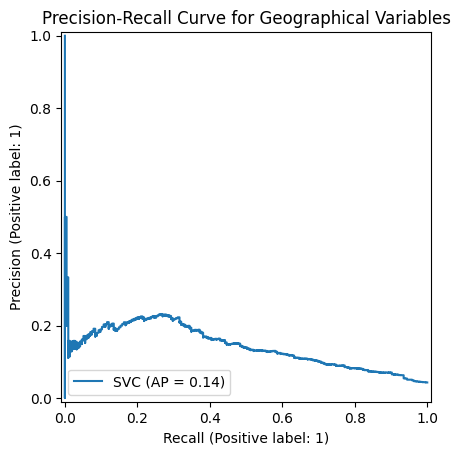

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(model, X_test_geo, y_test_geo)
plt.title("Precision-Recall Curve for Geographical Variables")
plt.show()


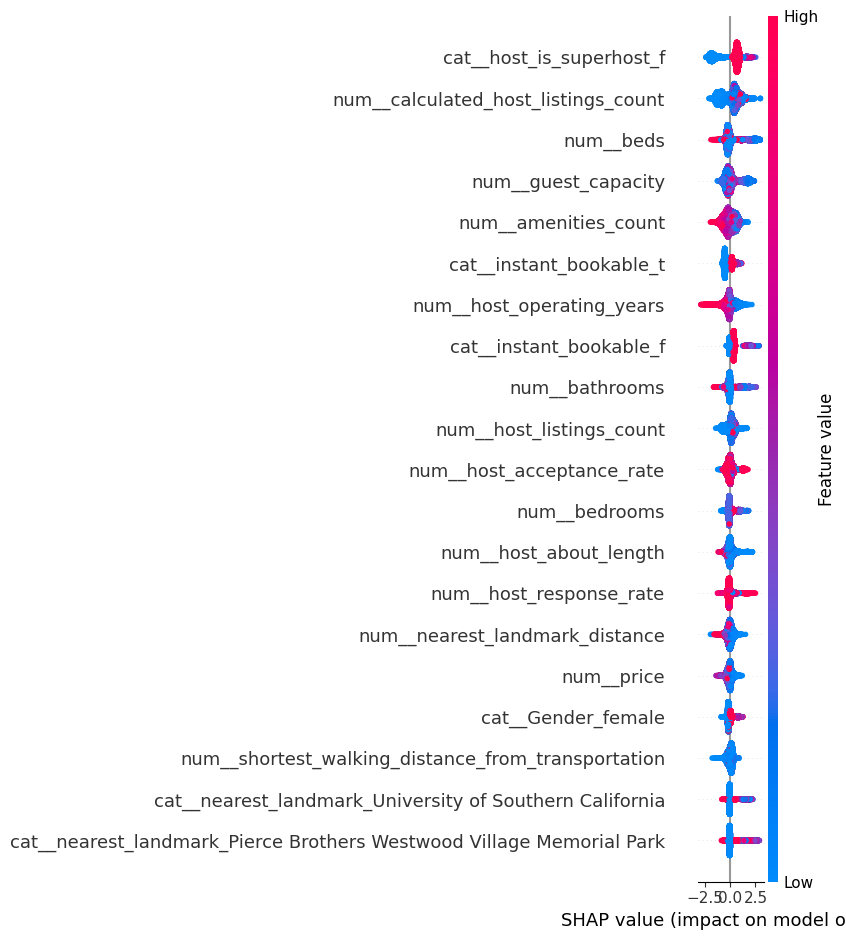

In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_geo_resampled)

# Visualize SHAP values for Gender_male
shap.summary_plot(shap_values, X_train_geo_resampled, feature_names=feature_names)


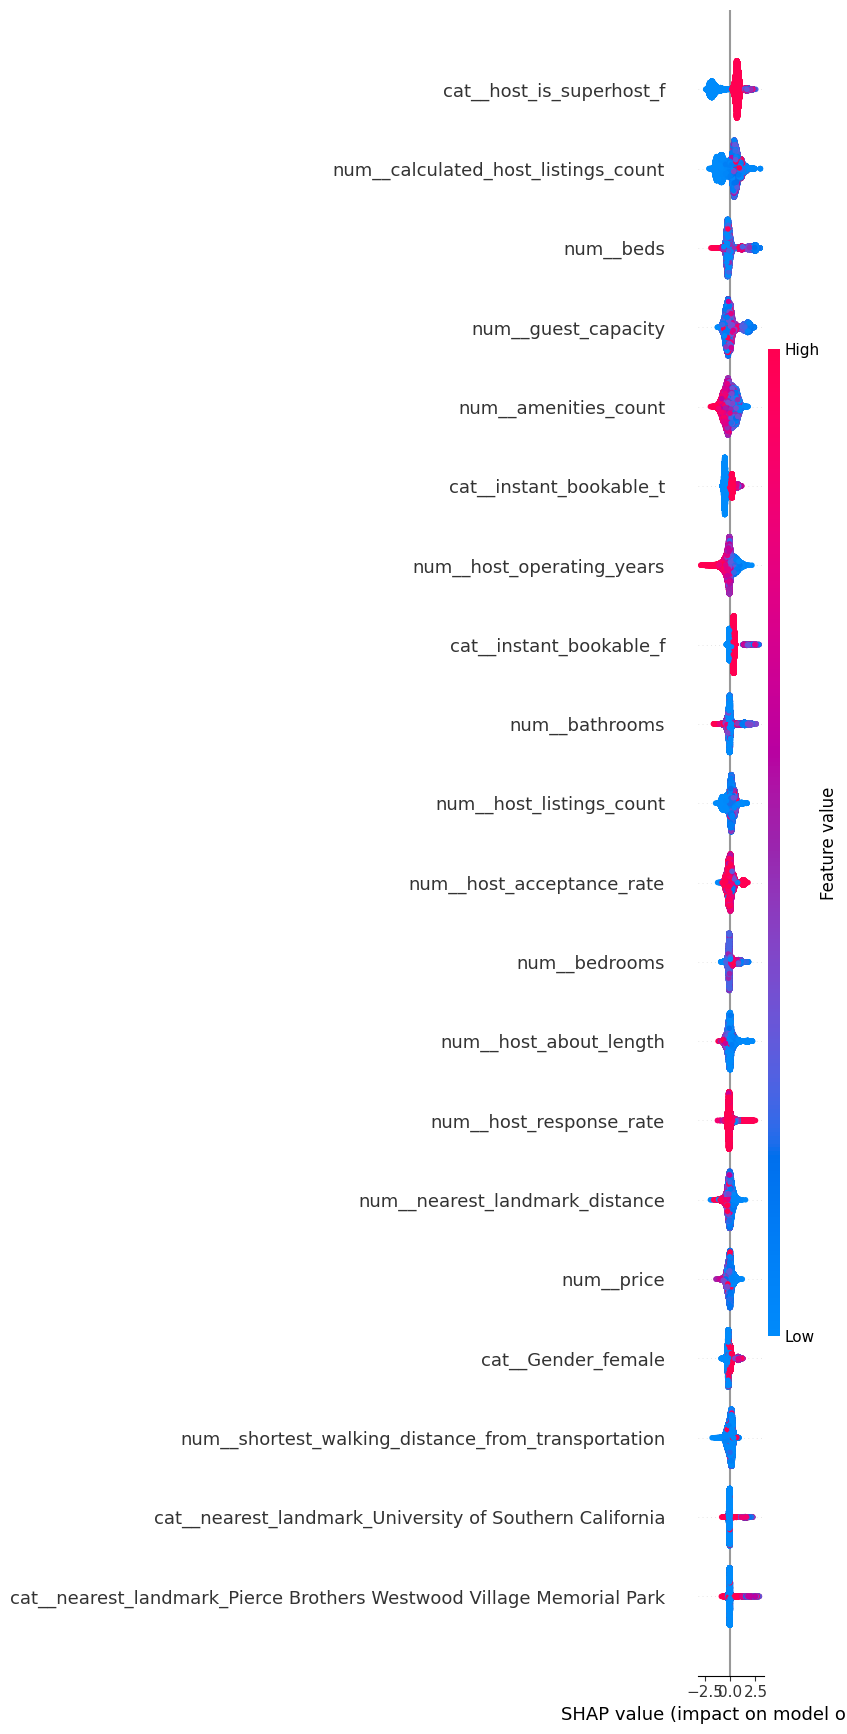

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import shap

# SHAP summary plot with adjusted figure size and font size
plt.figure(figsize=(10, 8))  # Increase figure size
shap.summary_plot(
    shap_values,
    X_train_geo_resampled,
    feature_names=feature_names,
    plot_size=0.8  # Adjust plot size to prevent overlapping
)

# Save the plot as a file (optional)
plt.savefig("shap_summary_plot_adjusted.png", bbox_inches="tight", dpi=300)
plt.show()


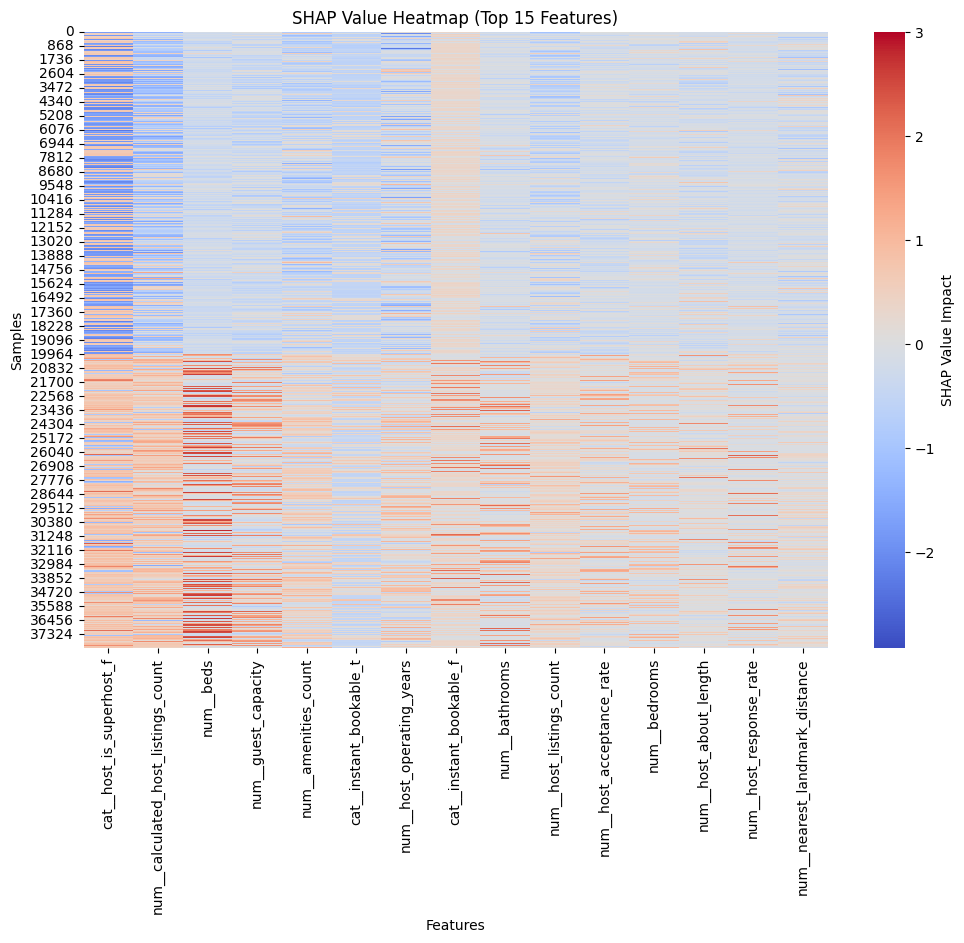

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SHAP 값을 DataFrame으로 변환
shap_values_df = pd.DataFrame(shap_values, columns=feature_names)

# 히트맵 생성 (상위 15개 변수만 표시)
top_features = shap_values_df.abs().mean().sort_values(ascending=False).head(15).index
plt.figure(figsize=(12, 8))
sns.heatmap(
    shap_values_df[top_features],
    cmap="coolwarm",
    cbar_kws={'label': 'SHAP Value Impact'},
    xticklabels=top_features
)
plt.title("SHAP Value Heatmap (Top 15 Features)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()


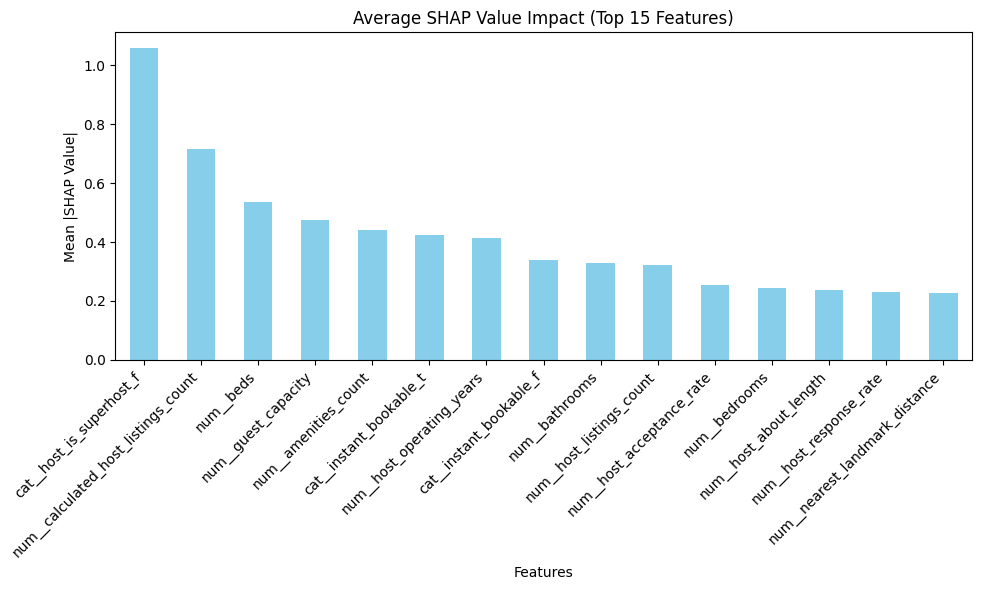

In [ ]:
# 변수별 평균 절대 SHAP 값 계산
mean_shap_values = shap_values_df.abs().mean().sort_values(ascending=False)

# 상위 15개 변수만 표시
top_mean_shap = mean_shap_values.head(15)

# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
top_mean_shap.plot(kind='bar', color='skyblue')
plt.title("Average SHAP Value Impact (Top 15 Features)")
plt.ylabel("Mean |SHAP Value|")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# ------------------------------------------------------------------------------------------------- #

In [ ]:
# Step 1: Define categorical and numerical features
categorical_features = ['Gender', 'host_response_time', 'host_is_superhost',
                        'host_has_profile_pic', 'room_type', 'instant_bookable',
                        'nearest_landmark']
numerical_features = [col for col in thesis_data.columns if col not in categorical_features + ['review_scores_rating', 'review_rating_class']]

# Step 2: Encode categorical variables and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Step 3: Train-Test Split (with Stratified Split to maintain class ratio)
X = thesis_data.drop(columns=['review_scores_rating', 'review_rating_class'])  # Features
y = thesis_data['review_rating_class']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Apply the preprocessing pipeline to the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Step 5: Apply SMOTE to the processed training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Step 6: Check class distribution after SMOTE
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", pd.Series(y_train_resampled).value_counts())

ValueError: A given column is not a column of the dataframe

In [ ]:
# Step 4: Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Step 5: Preprocess the test data
X_test_processed = preprocessor.transform(X_test)

# Step 6: Evaluate the model on the test set
y_pred = model.predict(X_test_processed)

# Classification Report and Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[  38  177]
 [ 119 4652]]

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.18      0.20       215
           1       0.96      0.98      0.97      4771

    accuracy                           0.94      4986
   macro avg       0.60      0.58      0.59      4986
weighted avg       0.93      0.94      0.94      4986



In [ ]:
# Rebalancing
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Step 5: Preprocess the test data
X_test_processed = preprocessor.transform(X_test)

# Step 6: Evaluate the model on the test set
y_pred = model.predict(X_test_processed)

# Classification Report and Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[  38  177]
 [ 119 4652]]

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.18      0.20       215
           1       0.96      0.98      0.97      4771

    accuracy                           0.94      4986
   macro avg       0.60      0.58      0.59      4986
weighted avg       0.93      0.94      0.94      4986



In [ ]:
from imblearn.combine import SMOTETomek

# Apply SMOTETomek to the training data
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_processed, y_train)

# Check class distribution after SMOTETomek
print("Class distribution before SMOTETomek:", y_train.value_counts())
print("Class distribution after SMOTETomek:", pd.Series(y_train_resampled).value_counts())


Class distribution before SMOTETomek: rating_class
1    19085
0      858
Name: count, dtype: int64
Class distribution after SMOTETomek: rating_class
1    19037
0    19037
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train the model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_resampled, y_train_resampled)


# Preprocess the test data
X_test_processed = preprocessor.transform(X_test)

# Evaluate the model
y_pred = model.predict(X_test_processed)

# Classification Report and Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC Score
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("\nROC-AUC Score:", roc_auc)


Confusion Matrix:
 [[  39  176]
 [ 123 4648]]

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.18      0.21       215
           1       0.96      0.97      0.97      4771

    accuracy                           0.94      4986
   macro avg       0.60      0.58      0.59      4986
weighted avg       0.93      0.94      0.94      4986


ROC-AUC Score: 0.8230135557364504


In [ ]:
from xgboost import XGBClassifier

# Train XGBoost with scale_pos_weight
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate XGBoost
y_pred = xgb_model.predict(X_test_processed)
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.20      0.25       215
           1       0.96      0.98      0.97      4771

    accuracy                           0.95      4986
   macro avg       0.64      0.59      0.61      4986
weighted avg       0.94      0.95      0.94      4986



In [ ]:
from sklearn.model_selection import GridSearchCV

# Random Forest 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'scale_pos_weight': [5, 10, 15],
}

# Grid Search
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',  # Focus on F1 score for macro average
    cv=3,
    verbose=1
)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test_processed)
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 15}
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.09      0.14       215
           1       0.96      0.99      0.98      4771

    accuracy                           0.95      4986
   macro avg       0.66      0.54      0.56      4986
weighted avg       0.93      0.95      0.94      4986



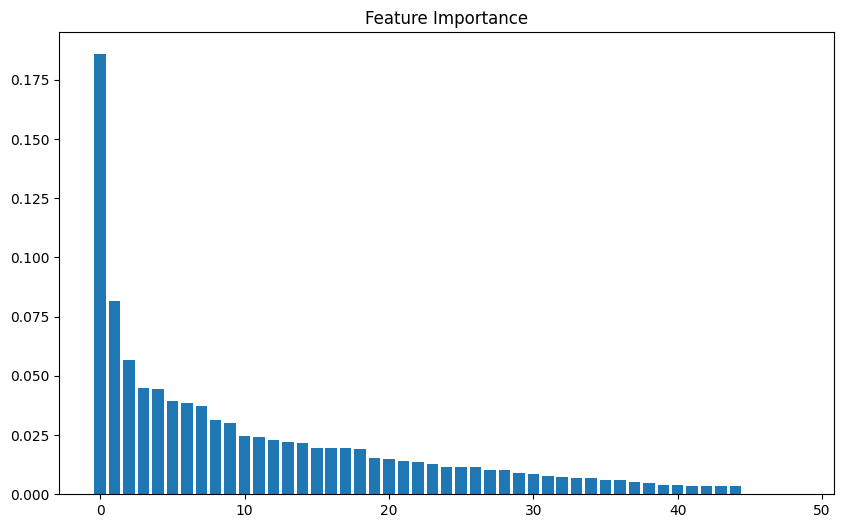

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot feature importance
feature_importances = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.title("Feature Importance")
plt.show()


In [ ]:
#  Ensemble Models XGBoost와 다른 모델을 결합하여 성능을 높일 수 있습니다. 예를 들어, Random Forest와 XGBoost의 예측 결과를 조합하거나 VotingClassifier를 사용하세요.
from sklearn.ensemble import VotingClassifier

# Combine models
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft')

voting_model.fit(X_train_resampled, y_train_resampled)
y_pred = voting_model.predict(X_test_processed)

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.18      0.22       215
           1       0.96      0.98      0.97      4771

    accuracy                           0.94      4986
   macro avg       0.62      0.58      0.59      4986
weighted avg       0.93      0.94      0.94      4986

